In [1]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
import datetime

sns.set_style('whitegrid')
os.environ['KMP_DUPLICATE_LIB_OK']='True'

/Users/a_yoshino/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
/Users/a_yoshino/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
TRAIN_DATA_PATH = '../input/train.csv'

exiting_train = pd.read_csv(TRAIN_DATA_PATH)
target = exiting_train["target"]

In [3]:
def get_data(cnt):
    """
    データをcsvファイルから取得し、importanceの上位何割かを特徴量に使用
    """
    #importance何点以上を使用するか
    border = 2500
    
    file_train_name= f"../output/train_new_var_{cnt}.csv"
    file_test_name= f"../output/test_new_var_{cnt}.csv"
    
    importance_file_name = f"../output/new_feature_importance_var{cnt}.csv"


    origin_train = pd.read_csv(file_train_name)
    origin_test = pd.read_csv(file_test_name)
    importance_data = pd.read_csv(importance_file_name)
    
    best_train = origin_train[importance_data[importance_data["importance"]>= border]["Feature"]]
    best_test = origin_test[importance_data[importance_data["importance"]>= border]["Feature"]]
        
    return best_train, best_test

In [25]:
train = pd.DataFrame([])
test = pd.DataFrame([])

#使用する特徴量番号をリストに入れる
var_num_li =[0, 1, 2]

for var_num in var_num_li:
    train_data, test_data= get_data(var_num)
    train = pd.concat([train, train_data], axis=1)    
    test = pd.concat([test, test_data], axis=1)

In [38]:
#ファイルの名前生成
file_name = ""
for num in var_num_li:
    file_name = file_name + str(num) + "_"
file_name = file_name[:-1]
print(file_name)

0_1_2


In [39]:
train.to_csv(f"../output/new/new_train_var{file_name}.csv")
test.to_csv(f"../output/new/new_test_var{file_name}.csv")

In [10]:
features = train.columns

In [11]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

In [13]:
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=44000)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx], label=target.iloc[val_idx])

    num_round = 30000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train.iloc[val_idx], num_iteration=clf.best_iteration)
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = features
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.726585	valid_1's auc: 0.702413
[2000]	training's auc: 0.751005	valid_1's auc: 0.71645
[3000]	training's auc: 0.765607	valid_1's auc: 0.723765
[4000]	training's auc: 0.776033	valid_1's auc: 0.727221
[5000]	training's auc: 0.784227	valid_1's auc: 0.729375
[6000]	training's auc: 0.79106	valid_1's auc: 0.73053
[7000]	training's auc: 0.797214	valid_1's auc: 0.731364
[8000]	training's auc: 0.80299	valid_1's auc: 0.731542
[9000]	training's auc: 0.8083	valid_1's auc: 0.731839
[10000]	training's auc: 0.813178	valid_1's auc: 0.731807
[11000]	training's auc: 0.817986	valid_1's auc: 0.731671
Early stopping, best iteration is:
[8593]	training's auc: 0.806145	valid_1's auc: 0.732051
Fold 1
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.72684	valid_1's auc: 0.701523
[2000]	training's auc: 0.750978	valid_1's auc: 0.716081
[3000]	training's auc: 0.765588	valid_1's au

/Users/a_yoshino/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


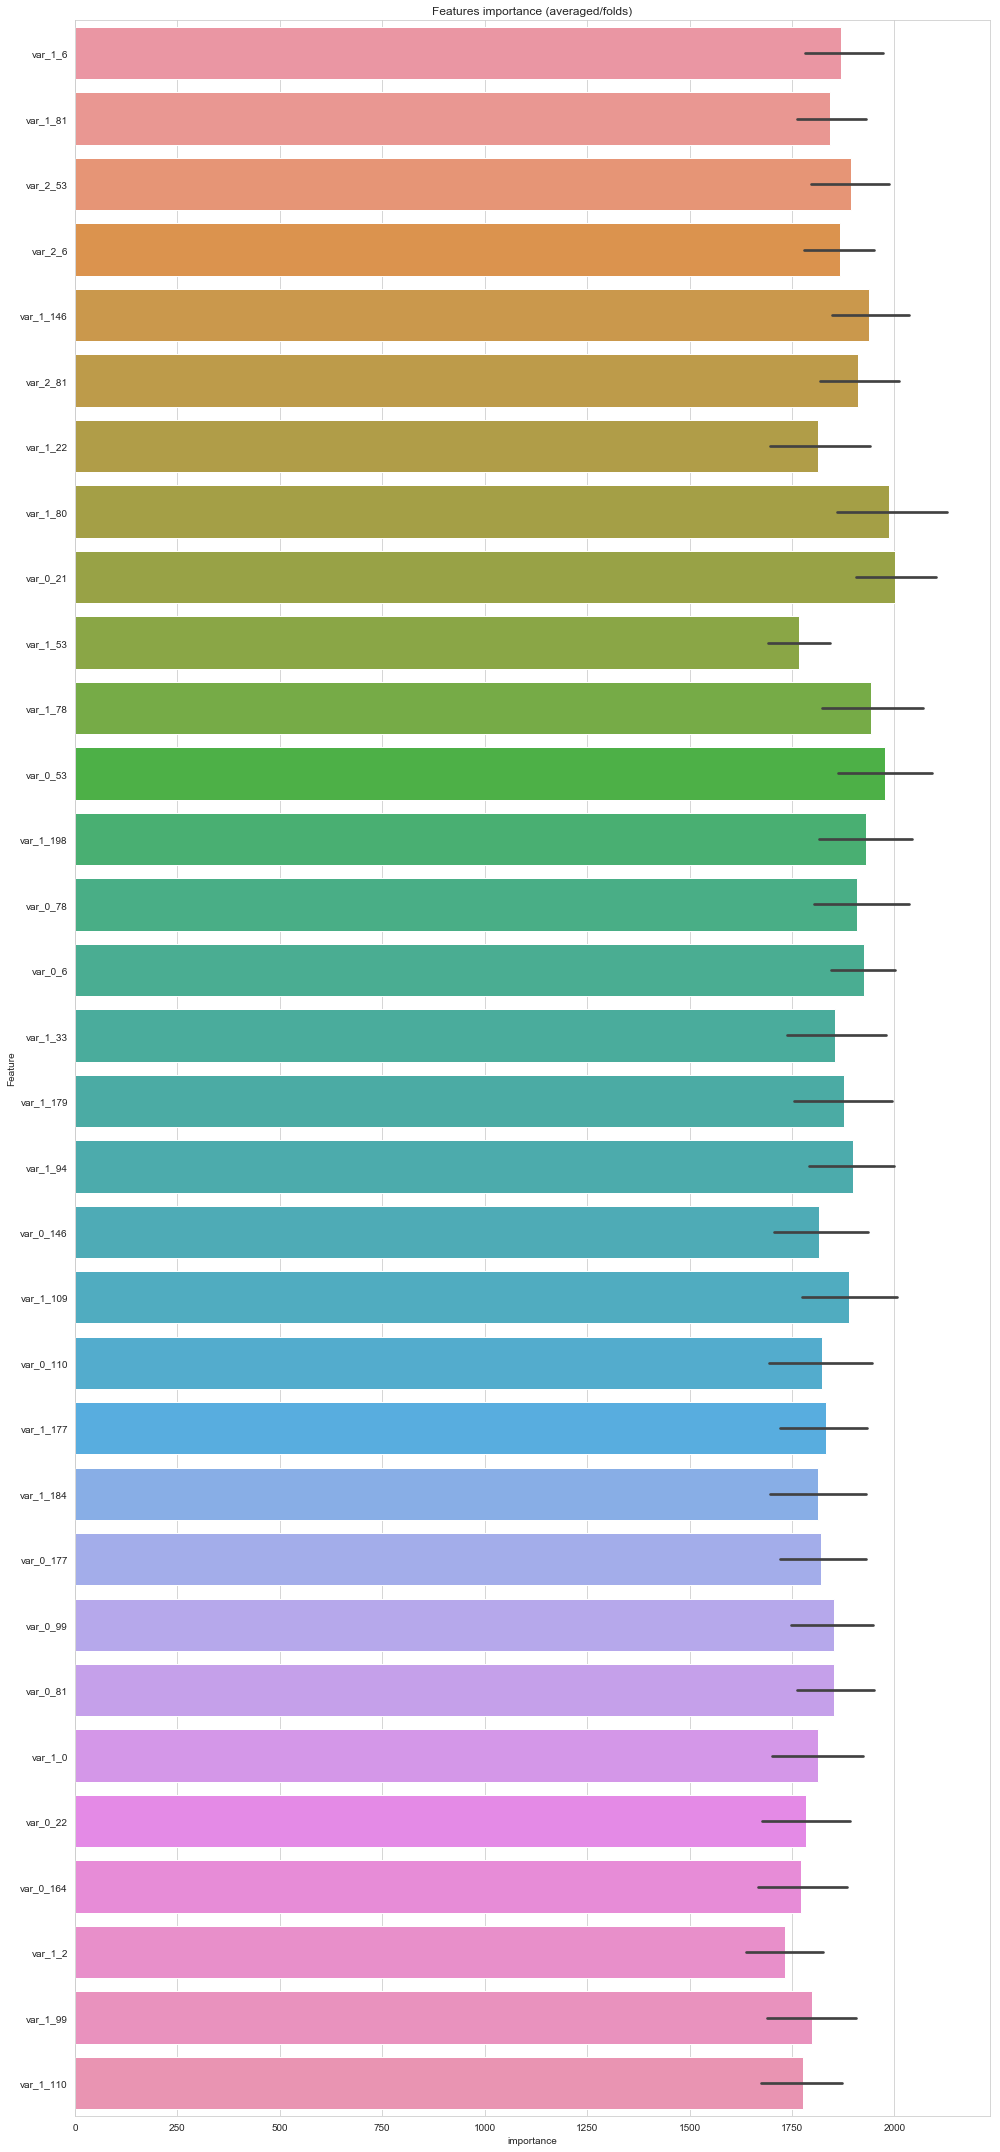

In [14]:
cols = (feature_importance[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:6000].index)
best_features = feature_importance.loc[feature_importance.Feature.isin(cols)]

plt.figure(figsize=(14,30))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')

In [21]:
feature_importance.to_csv(f"importamce_1.csv", index=False)
test

,var_0_6,var_0_21,var_0_22,var_0_53,var_0_78,var_0_81,var_0_99,var_0_110,var_0_146,var_0_164,...,var_2_53,var_2_53,var_2_6,var_2_6,var_2_6,var_2_53,var_2_81,var_2_6,var_2_81,var_2_81
0,16.9149,29.8720,12.6555,18.3869,14.1848,27.9716,12.9241,14.8318,22.7449,2.4551,...,20.2749,20.2749,18.8029,18.8029,18.8029,20.2749,29.8596,18.8029,29.8596,29.8596
1,14.5500,11.6693,13.7882,15.3785,14.9059,22.5710,7.1138,10.2679,17.2948,-2.1268,...,18.1528,18.1528,17.3243,17.3243,17.3243,18.1528,25.3453,17.3243,25.3453,25.3453
2,10.3777,17.8523,10.2300,11.1337,13.1414,19.8126,7.2645,14.1723,17.1576,4.9445,...,15.7917,15.7917,15.0357,15.0357,15.0357,15.7917,24.4706,15.0357,24.4706,24.4706
3,13.4771,21.0901,11.5081,14.7910,14.0434,23.9749,11.1539,18.8819,17.2337,-2.5406,...,18.2756,18.2756,16.9617,16.9617,16.9617,18.2756,27.4595,16.9617,27.4595,27.4595
4,18.5653,28.0117,18.5012,17.3852,17.8631,28.4719,11.8206,18.0991,24.6385,-0.2727,...,19.8089,19.8089,20.9890,20.9890,20.9890,19.8089,30.8956,20.9890,30.8956,30.8956
5,10.2329,28.8965,12.4942,11.1984,12.4770,22.0669,5.2885,9.3771,17.0069,-7.2947,...,13.8180,13.8180,12.8525,12.8525,12.8525,13.8180,24.6865,12.8525,24.6865,24.6865
6,12.6294,28.9397,12.3662,14.4236,12.1486,20.9917,6.7313,14.3429,14.3589,2.2470,...,13.3215,13.3215,11.5273,11.5273,11.5273,13.3215,19.8896,11.5273,19.8896,19.8896
7,23.2631,35.5629,23.1106,23.7116,24.8459,36.0914,16.5965,22.8545,31.8136,13.4522,...,19.8070,19.8070,19.3585,19.3585,19.3585,19.8070,32.1868,19.3585,32.1868,32.1868
8,11.3242,25.6388,14.7679,13.5240,13.7209,23.0832,3.5909,14.5130,16.5170,8.3438,...,20.2545,20.2545,18.0547,18.0547,18.0547,20.2545,29.8137,18.0547,29.8137,29.8137
9,13.8319,23.0387,11.0546,16.7105,15.6007,25.6427,9.0236,14.5315,18.7219,0.5755,...,20.9984,20.9984,18.1198,18.1198,18.1198,20.9984,29.9306,18.1198,29.9306,29.9306


In [24]:
score = round(roc_auc_score(target, oof), 4)
sub = pd.DataFrame({"ID_code": test.index})
sub["target"]=predictions
sub.to_csv(f"submission_new_var{file_name}_{score}.csv", index=False)

,ID_code,target
0,0,0.993197
1,1,0.978754
2,2,0.964571
3,3,0.988699
4,4,0.994932
5,5,0.992377
6,6,0.988095
7,7,0.993172
8,8,0.987693
9,9,0.993200
